<a href="https://colab.research.google.com/github/KasraOstad/Vineyard-Classification-in-Sussex/blob/master/s1time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was used for time-series analysis of Sentinel-1 data

In [1]:
#import google earth engine and useful libraries
!pip install folium
!pip install geehydro
import ee
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

#Authenticate to the Earth Engine servers
ee.Authenticate()

#Initialize the API
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=a2k0Q6NgAZHobr_FnTfzehbJKJ1Fam3617lGlFexU9U&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/3QHsouBUSL_06h4oZ83L0raP1wzQtp8jNdN9clUSWjY1s753vTUTsEI

Successfully saved authorization token.


In [2]:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filterDate('2019-01-01','2020-01-01')

#Define Area of interest

area_list= list ([(-0.464307, 50.958657),(-0.462859, 50.958934),(-0.462880, 50.957893),(-0.465637, 50.958217),(-0.464307, 50.958657)])
AOI=ee.Geometry.Polygon(area_list)

sentinel1=sentinel1.filterBounds(AOI)


vv_vh = sentinel1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))

vv_vh_list=vv_vh.toList(vv_vh.size())     

sentinel1_ts=[]

for i in range(0, vv_vh_list.size().getInfo()):
  if i%1==0:
    image=ee.Image(vv_vh_list.get(i))
    sentinel1_ts.append(image)
 

len(sentinel1_ts)

166

In [3]:
filtered=[]

for index, element in enumerate(sentinel1_ts):
  if index % 3 == 0:
    filtered.append(element)

len(filtered)

56

In [4]:
def ymdList(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())

find_dates=ee.ImageCollection(filtered)
dates=ymdList(find_dates)

dates



['20190102',
 '20190108',
 '20190114',
 '20190124',
 '20190126',
 '20190205',
 '20190207',
 '20190219',
 '20190301',
 '20190307',
 '20190313',
 '20190319',
 '20190331',
 '20190402',
 '20190412',
 '20190414',
 '20190424',
 '20190430',
 '20190506',
 '20190512',
 '20190518',
 '20190530',
 '20190601',
 '20190611',
 '20190613',
 '20190623',
 '20190625',
 '20190705',
 '20190711',
 '20190717',
 '20190729',
 '20190731',
 '20190810',
 '20190812',
 '20190822',
 '20190824',
 '20190903',
 '20190905',
 '20190915',
 '20190921',
 '20190927',
 '20191006',
 '20191009',
 '20191018',
 '20191021',
 '20191030',
 '20191102',
 '20191111',
 '20191114',
 '20191123',
 '20191126',
 '20191205',
 '20191208',
 '20191217',
 '20191220',
 '20191229']

In [5]:

#Features of known vineyards:

nutbourne=ee.Feature(ee.Geometry.Polygon(coords = [[[-0.464307, 50.958657], [-0.462859, 50.958934], [-0.462880, 50.957893], [-0.465637, 50.958217], [-0.464307, 50.958657]]])) 
blackdog=ee.Feature(ee.Geometry.Polygon(coords =[[[-0.111095,50.907673], [-0.112039,50.906455], [-0.110086,50.906185], [-0.109464,50.907491], [-0.111095,50.907673]]]))  
stopham=ee.Feature(ee.Geometry.Polygon(coords =[[[-0.539676,50.959777], [-0.536996,50.959608], [-0.537278,50.958873], [-0.540022,50.959107], [-0.539676,50.959777]]]))                                                                       
albury=ee.Feature(ee.Geometry.Polygon(coords =[[[-0.485404,51.229119], [-0.485325,51.226550], [-0.4834528,51.226518], [-0.483390,51.229149], [-0.485404,51.229119]]])) 
coolhurst=ee.Feature(ee.Geometry.Polygon(coords =[[[-0.298754,51.052306], [-0.297863,51.050897], [-0.295439,51.050870], [-0.295567,51.052933], [-0.298754,51.052306]]])) 



In [6]:
def veg_timeseries(region,list_of_images):
  VVstats=[]
  VHstats=[]
  for image in list_of_images:
    stat_dict=image.reduceRegion(**{
      'reducer': ee.Reducer.median(),
      'geometry': region.geometry(),
      'scale': 10,
      'maxPixels': 1e9
    })
    VHstats.append(stat_dict.getInfo().get('VH'))
    VVstats.append(stat_dict.getInfo().get('VV'))
  return VHstats,VVstats

nutbourne_VH,nutbourne_VV=veg_timeseries(nutbourne,filtered)




In [7]:
stopham_VH,stopham_VV=veg_timeseries(stopham,filtered)
albury_VH,albury_VV=veg_timeseries(albury,filtered)
coolhurst_VH,coolhurst_VV=veg_timeseries(coolhurst,filtered)

Text(0, 0.5, 'Median VV of region')

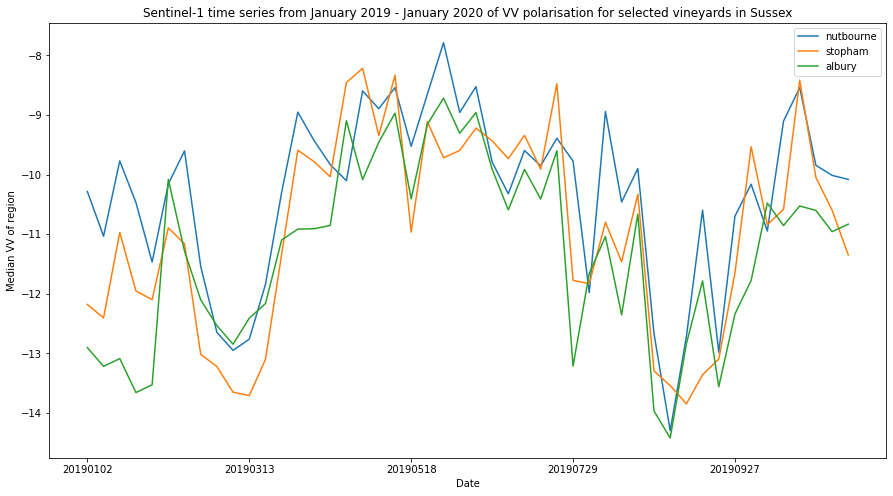

In [8]:
import pandas as pd

timeseries_df=pd.DataFrame(data=nutbourne_VV, index=dates, columns=['nutbourne'])
timeseries_df['stopham']=stopham_VV
timeseries_df['albury']=albury_VV

timeseries_df=timeseries_df.dropna()
ax=timeseries_df.plot.line(figsize=(15,8),title='VV polarisation time series from January 2019 - January 2020 for selected vineyards in Sussex')
ax.set_xlabel("Date")
ax.set_ylabel("Median VV of region")



Text(0, 0.5, 'Median VH of region')

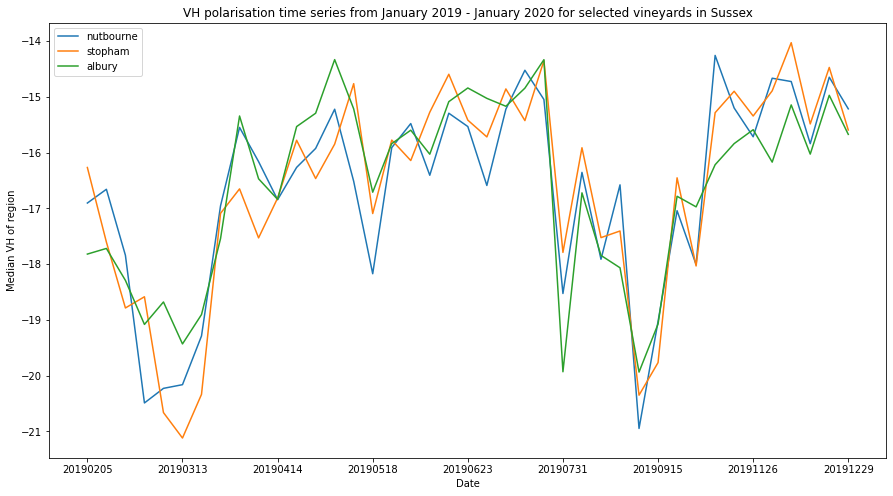

In [13]:
timeseries_df=pd.DataFrame(data=nutbourne_VH, index=dates, columns=['nutbourne'])
timeseries_df['stopham']=stopham_VH
timeseries_df['albury']=coolhurst_VH
#timeseries_df['coolhurst']=coolhurst_VH
timeseries_df=timeseries_df.dropna()

ax=timeseries_df.plot.line(figsize=(15,8),title='VH polarisation time series from January 2019 - January 2020 for selected vineyards in Sussex')
ax.set_xlabel("Date")
ax.set_ylabel("Median VH of region")


In [10]:
grass1=ee.Feature(ee.Geometry.Polygon(coords=[[-0.07410789723823646, 50.98894440841386], [-0.07467747053633884, 50.98895379836258], [-0.07494937685745727, 50.98926981341378], [-0.07465170561651964, 50.98957644047522], [-0.07408212470674314, 50.98956705031921], [-0.0738102226496698, 50.98925103330904], [-0.07410789723823646, 50.98894440841386]]))
grass2=ee.Feature(ee.Geometry.Polygon(coords=[[[-0.2084964824190066, 50.86615718242087], [-0.2087924746738251, 50.86585019130413], [-0.2093605901523409, 50.8658589095793], [-0.209632720936663, 50.86617461916353], [-0.2093367293526937, 50.86648168253753], [-0.2087686063126123, 50.86647296407003], [-0.2084964824190066, 50.86615718242087]]]))
grass3=ee.Feature(ee.Geometry.Polygon(coords=[[[-0.04262071767015235, 50.91770134072426], [-0.04291812537595823, 50.91739478899557], [-0.04348681430840379, 50.9174043214568], [-0.04375810311504533, 50.91772040585708], [-0.04346069866005398, 50.91802696154554], [-0.04289200214749488, 50.91801742887397], [-0.04262071767015235, 50.91770134072426]]]))

grass1_VH,grass1_VV=veg_timeseries(grass1,filtered)
grass2_VH,grass2_VV=veg_timeseries(grass2,filtered)
grass3_VH,grass3_VV=veg_timeseries(grass3,filtered)

Text(0, 0.5, 'Median VH of region')

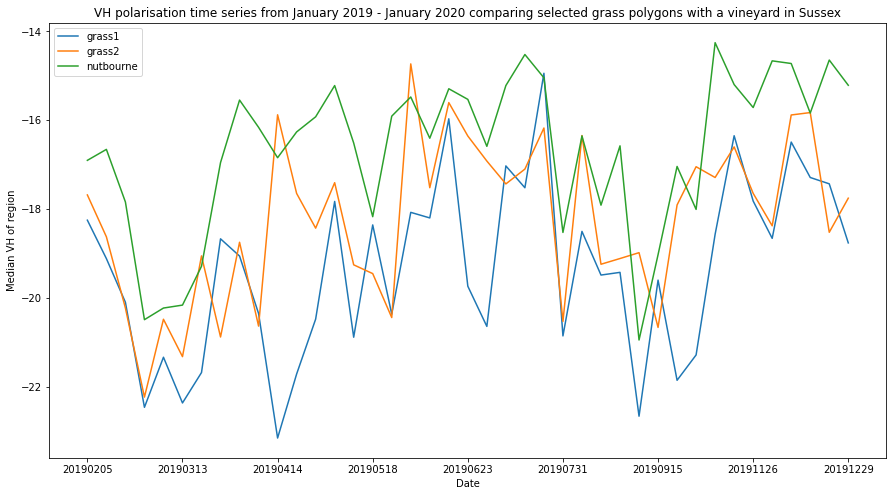

In [11]:

timeseries_df=pd.DataFrame(data=grass1_VH, index=dates, columns=['grass1'])
#timeseries_df['grass2']=grass2_VH
timeseries_df['grass2']=grass3_VH
timeseries_df['nutbourne']=nutbourne_VH

timeseries_df=timeseries_df.dropna()
ax=timeseries_df.plot.line(figsize=(15,8),title='VH polarisation time series from January 2019 - January 2020 comparing selected grass polygons with a vineyard in Sussex')
ax.set_xlabel("Date")
ax.set_ylabel("Median VH of region")

Text(0, 0.5, 'Median VV of region')

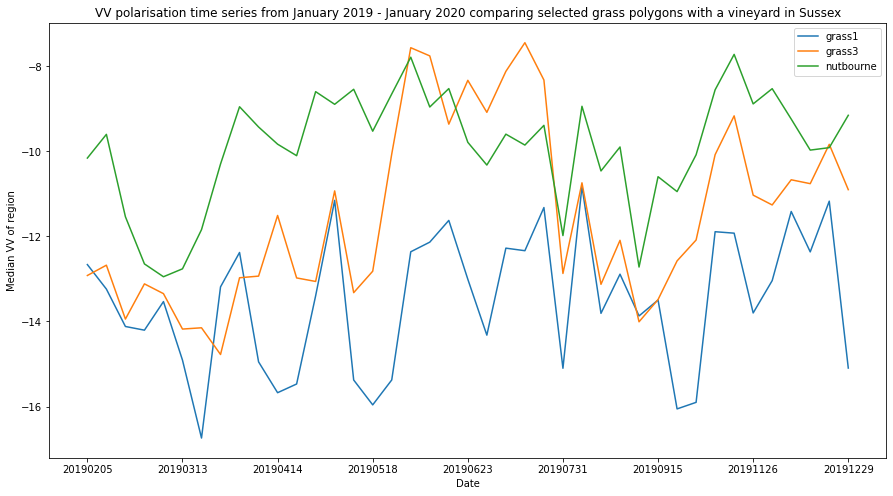

In [12]:
timeseries_df=pd.DataFrame(data=grass1_VV, index=dates, columns=['grass1'])
#timeseries_df['grass2']=grass2_VH
timeseries_df['grass3']=grass3_VV
timeseries_df['nutbourne']=nutbourne_VV

timeseries_df=timeseries_df.dropna()
ax=timeseries_df.plot.line(figsize=(15,8),title='VV polarisation time series from January 2019 - January 2020 comparing selected grass polygons with a vineyard in Sussex')
ax.set_xlabel("Date")
ax.set_ylabel("Median VV of region")
